In [1]:
import os
import subprocess
from datetime import datetime, timezone

import matplotlib.pyplot as plt
import pandas as pd
from transformers import pipeline

%matplotlib inline

In [2]:
# Sentiment Analysis
#
# Model:   https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english
# Dataset: https://huggingface.co/datasets/stanfordnlp/sst2
#
# - ⚠️ The data is very different from my notes, so the classifier seems heavily biased towards negative label.
# - Only first 512 bytes of the notes are used, do something better.
# - NOTE: Maybe classify each sentence and merge the results?
# - tldr; this barely works as it is.

os.environ["TOKENIZERS_PARALLELISM"] = "false"

model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
revision = "af0f99b"
classifier = pipeline("sentiment-analysis", model=model, revision=revision)

In [3]:
# This should have been a neutral example, but is negative with high
# confidence from this model. My notes have a lot of similar explainers, which
# all end up 🟥.

example = "Machine learning rely on non linearities like relu and sigmoid"
result = [{"label": "NEGATIVE", "score": 0.9612146615982056}]
assert classifier(example) == result

In [4]:
def ctime(root, path, filename):
    """Guess created timestamp from disk, git and filename"""

    sentinel = datetime.max.replace(tzinfo=timezone.utc)
    file_t, git_t, name_t = (sentinel, sentinel, sentinel)

    file_t = datetime.fromtimestamp(os.stat(path).st_ctime, tz=timezone.utc)

    # Creation time from the oldest commit that introduced the file
    cmd = [
        "git",
        "-C",
        root,
        "log",
        "-100",
        "--format=%ai",
        "--",
        path,
    ]
    try:
        git_ctime_str = subprocess.check_output(cmd).decode("utf-8").split("\n")[-1]
        git_t = datetime.fromisoformat(git_ctime_str)
    except ValueError:
        pass

    formats = ["%Y-%m-%d %H-%M", "%Y-%m-%d"]
    filename = filename.strip(".md").strip()
    for format in formats:
        try:
            # THIS TZ IS DEFINITELY SILLY
            name_t = datetime.strptime(filename, format).replace(tzinfo=timezone.utc)
        except ValueError:
            pass

    # print(f"{file_t=} \n{git_t=} \n{name_t=}")

    return pd.Timestamp(min([file_t, git_t, name_t]))

In [5]:
ctime(
    "/Users/j/Notes",
    "/Users/j/Notes/Journal/2015-01-04 19-45.md",
    "2015-01-04 19-45.md",
)

Timestamp('2015-01-04 19:45:00+0000', tz='UTC')

In [6]:
def read_md_files(directory):
    ignore = {".trash", ".archive", ".obsidian"}

    for root, _, files in os.walk(directory):
        if not any(i in root for i in ignore):
            for file in files:
                if file.endswith(".md") and (not root.startswith(".")):
                    path = os.path.join(root, file)
                    with open(path, "r") as f:
                        yield (
                            {
                                "name": file,
                                "path": path,
                                "contents": f.read(),
                                "ctime": ctime(directory, path, file),
                            }
                        )


metadata = read_md_files("/Users/j/Notes")
df = pd.DataFrame(metadata)
df = df.sort_values(by="ctime")

In [7]:
def sentiment(r):
    # TODO: Only on partial data, expand this to whole note
    sentiment = classifier(r.contents[:512])
    label = sentiment[0]["label"]
    score = sentiment[0]["score"]
    return score if label == "POSITIVE" else -score

In [8]:
df["score"] = df.apply(sentiment, axis="columns")

In [9]:
df["ctime"] = pd.DatetimeIndex(df["ctime"], tz="utc").tz_localize(None)
values = df[["ctime", "score"]].set_index("ctime")
values = values.resample("1d").mean()
values

,score
ctime,
2015-01-04,0.900205
2015-01-05,-0.994270
2015-01-06,-0.999779
2015-01-07,NaN
2015-01-08,NaN
...,...
2024-06-13,-0.042811
2024-06-14,-0.339181
2024-06-15,NaN


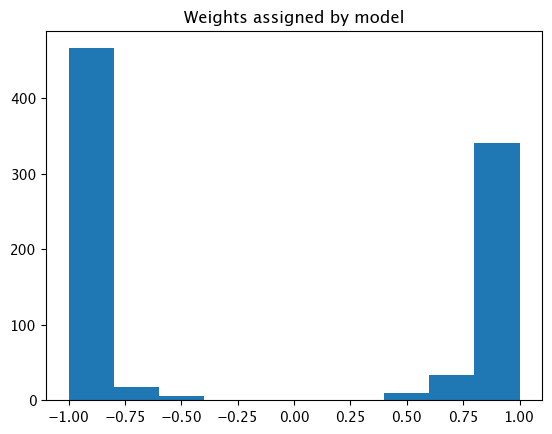

In [10]:
# My understanding of the classifier scores might not be correct.
#
# If a classifier says a sentence is 80% likely to be negative, does that also
# imply the document gets a score of .8 on some sadness scale? Or is that
# reasoning completely bogus?

plt.hist(df["score"].to_numpy())
plt.title("Weights assigned by model");

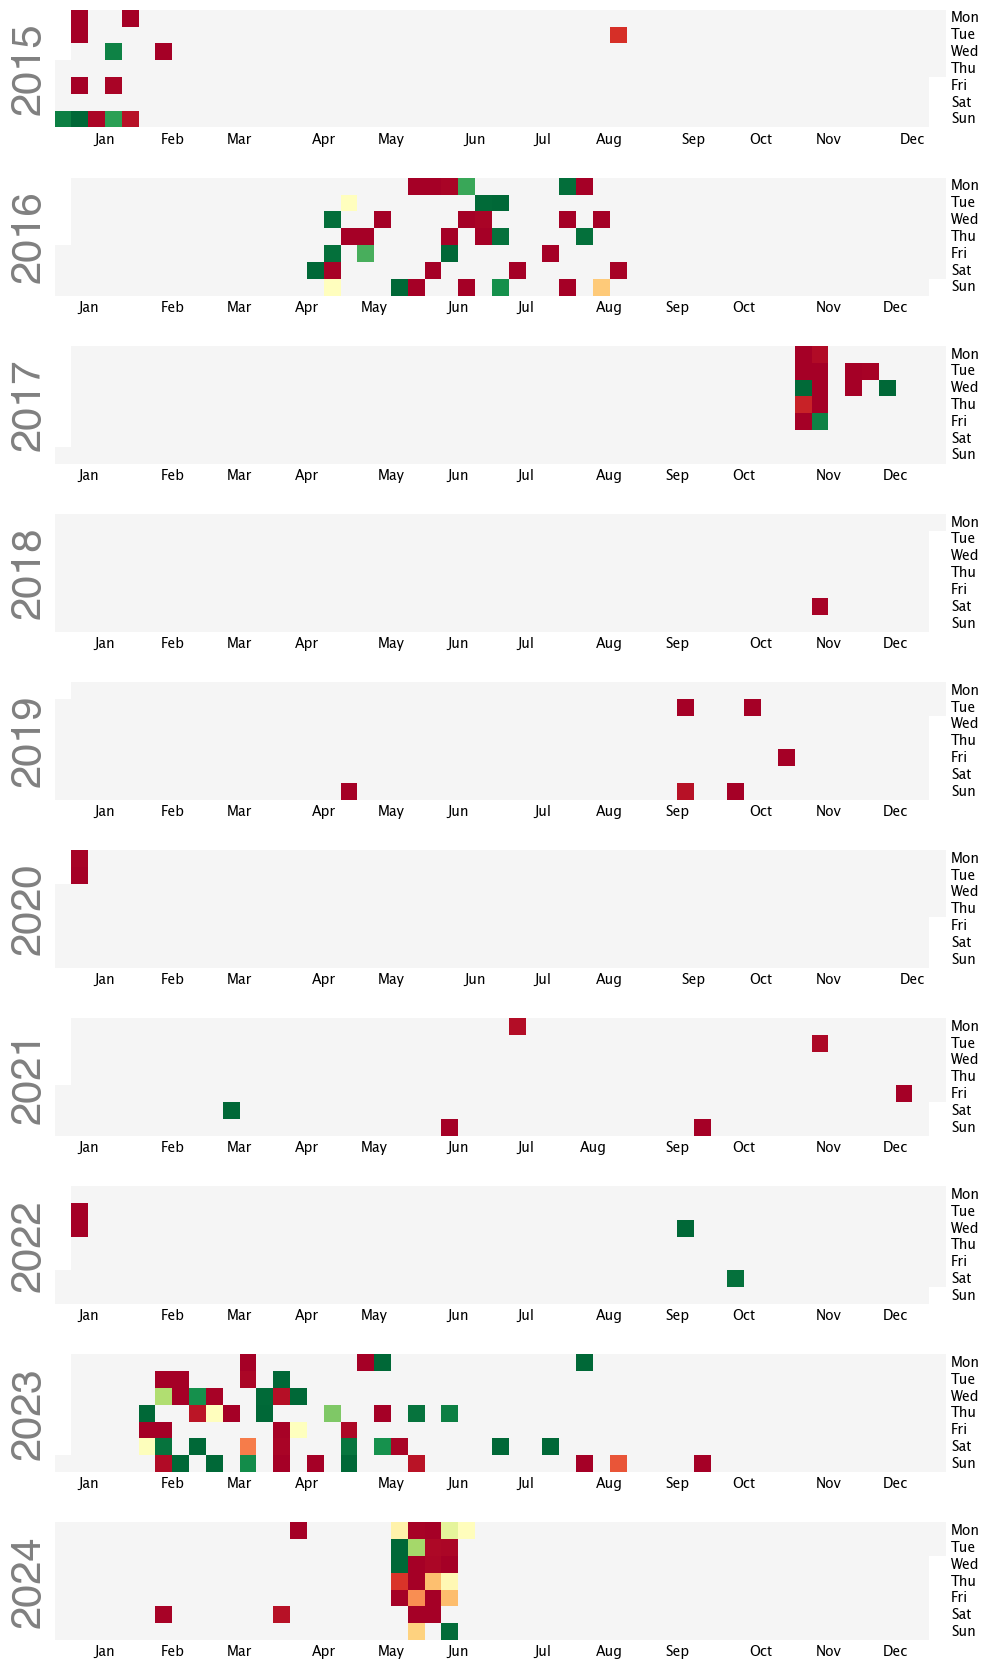

In [11]:
import calplot

calplot.calplot(values["score"], linewidth=0, cmap="RdYlGn", colorbar=False);